<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/Deep_Learning_and_Medical_Image_Analysis_for_Malaria_Detection_with_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![banner cnns ppgcc ufsc](http://www.lapix.ufsc.br/wp-content/uploads/2019/04/VC2.png)


<a href="https://colab.research.google.com/drive/1Mnr6nNmqNfM-3EWhrSDA_Xor6YBJJO42#scrollTo=4YAUfssdYcQ-"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Python-v.3.7-green.png" alt="Python Version" title="Python Version"></a>

# Deep Learning and Medical Image Analysis  for Malaria Detection with fast.ai

Posted by Aldo von Wangenheim -  <aldo.vw@ufsc.br> 

This is based upon the following material:
1.  [PyImagesearch::Deep Learning and Medical Image Analysis with Keras](https://www.pyimagesearch.com/2018/12/03/deep-learning-and-medical-image-analysis-with-keras/) - Example with malaria images y Adrian Rosebrock on December 3, 2018
1. [Malaria Datasets from the NIH](https://ceb.nlm.nih.gov/repositories/malaria-datasets/) - a repository of segmented cells from the thin blood smear slide images from the Malaria Screener research activity
1. [TowardsDataScience::Detecting Malaria with Deep Learning - AI for Social Good — A Healthcare Case Study](https://towardsdatascience.com/detecting-malaria-with-deep-learning-9e45c1e34b60)  - a review of the above by Dipanjan (DJ) Sarkar

I have adapted this material for usage with PyTorch/fast.ai in Mai 2019. It is an example used in my lecture available at: http://www.lapix.ufsc.br/ensino/visao-computacional

##Part 1 - Initializations 

Do what is in this section here below once each time you run this notebook...

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

###Testing your virtual machine on Google Colab...

*Se* você teve problemas: Veja qual a versão do driver, qual placa e qual versão de CUDA estão disponíveis...

In [2]:
!/opt/bin/nvidia-smi
!nvcc --version

Thu May  2 07:36:26 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

If you've had problems, look at the OS version...


In [3]:
!uname -a
!cat /etc/lsb-release

Linux 2e2c1a5b3c36 4.14.79+ #1 SMP Wed Dec 19 21:19:13 PST 2018 x86_64 x86_64 x86_64 GNU/Linux
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.2 LTS"


###Libray imports

Here we import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0" "fastai==1.0"


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback

# Imports for diverse utilities
from shutil import copyfile
import matplotlib.pyplot as plt
import operator
from PIL import Image
from sys import intern   # For the symbol definitions

## Utility Functions

### Export and restoration functions

In [0]:
# Export network for deployment and create a copy

def exportStageTo(learn, path):
    learn.export()
    # Faça backup diferenciado
    copyfile(path/'export.pkl', path/'export-malaria.pkl')
    
#exportStage1(learn, path)

In [0]:
# Restoration of a deployment model, for example in order to conitnue fine-tuning

def restoreStageFrom(path):
  # Restore a backup
  copyfile(path/'export-malaria.pkl', path/'export.pkl')
  return load_learner(path)
  
#learn = restoreStage1From(path)

### Download the  Malaria Data

In [12]:
!wget  --backups=1 -q https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
!wget  --backups=1 -q https://ceb.nlm.nih.gov/proj/malaria/malaria_cell_classification_code.zip
!ls -al

total 345208
drwxr-xr-x 1 root root      4096 May  2 07:45 .
drwxr-xr-x 1 root root      4096 May  2 07:35 ..
-rw-r--r-- 1 root root 353452851 Apr  6  2018 cell_images.zip
drwxr-xr-x 1 root root      4096 Apr 29 16:32 .config
-rw-r--r-- 1 root root     12581 Apr  6  2018 malaria_cell_classification_code.zip
drwxr-xr-x 1 root root      4096 Apr 29 16:32 sample_data


In [13]:
!unzip cell_images.zip

Archive:  cell_images.zip
   creating: cell_images/
   creating: cell_images/Parasitized/
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_166.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_167.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_169.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_171.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_201509

### Prepare your data

Change the name of the **cell_images** folder to **train**,  and then *mv* it on top of  a new *data* folder, so *fast.ai* can use it to automatically generate *train, validation* and *test* sets, without any further fuss...

In [0]:
!mv cell_images train
!mkdir data
!mv train data

Look at your data folder...

In [15]:
# Use apt install tree if you don't have this command installed yet
!apt install tree 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (579 kB/s)
Selecting previously unselected package tree.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [16]:
!tree ./data --dirsfirst --filelimit 10

./data
└── train
    ├── Parasitized [13780 entries exceeds filelimit, not opening dir]
    └── Uninfected [13780 entries exceeds filelimit, not opening dir]

3 directories, 0 files


Now, initialize a few variables...

In [0]:
bs = 256                # Batch size, 256 for small images on a T4 GPU...
size = 128              # Image size, 128x128 is a bit smaller than most of the images...
path = Path("./data")   # The path to the 'train' folder you created...

## Create your training and validation data  bunches

In the original material from PyImagesearch, which employs Keras, there's a long routine to create training, validation and test folders from the data. With fast.ai it is not necessary: if you only have a 'train' folder, you can split it while creating the DataBunch by simply passing a few parameters...

In [18]:
# Limit your augmentations: it's medical data! You do not want to phantasize data...
# Warping, for example, will let your images badly distorted, so don't do it!
# This dataset is big, so don't rotate the images either. Lets stick to flipping...
tfms = get_transforms(max_rotate=None, max_warp=None, max_zoom=1.0)
# Create the DataBunch!
# Remember that you'll have images that are bigger than 128x128 and images that are smaller,   
# so squish them all in order to occupy exactly 128x128 pixels...
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH, 
                                  valid_pct = 0.2, bs=bs)
#
print('Transforms = ', len(tfms))
# Save the DataBunch in case the training goes south... so you won't have to regenerate it..
# Remember: this DataBunch is tied to the batch size you selected. 
data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')
# Show the statistics of the Bunch...
print(data.classes)
data

Transforms =  2
['Parasitized', 'Uninfected']


ImageDataBunch;

Train: LabelList (22047 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: data;

Valid: LabelList (5511 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Parasitized,Uninfected,Parasitized,Uninfected,Uninfected
Path: data;

Test: None

### Look at your DataBunch to see if the augmentations are acceptable...

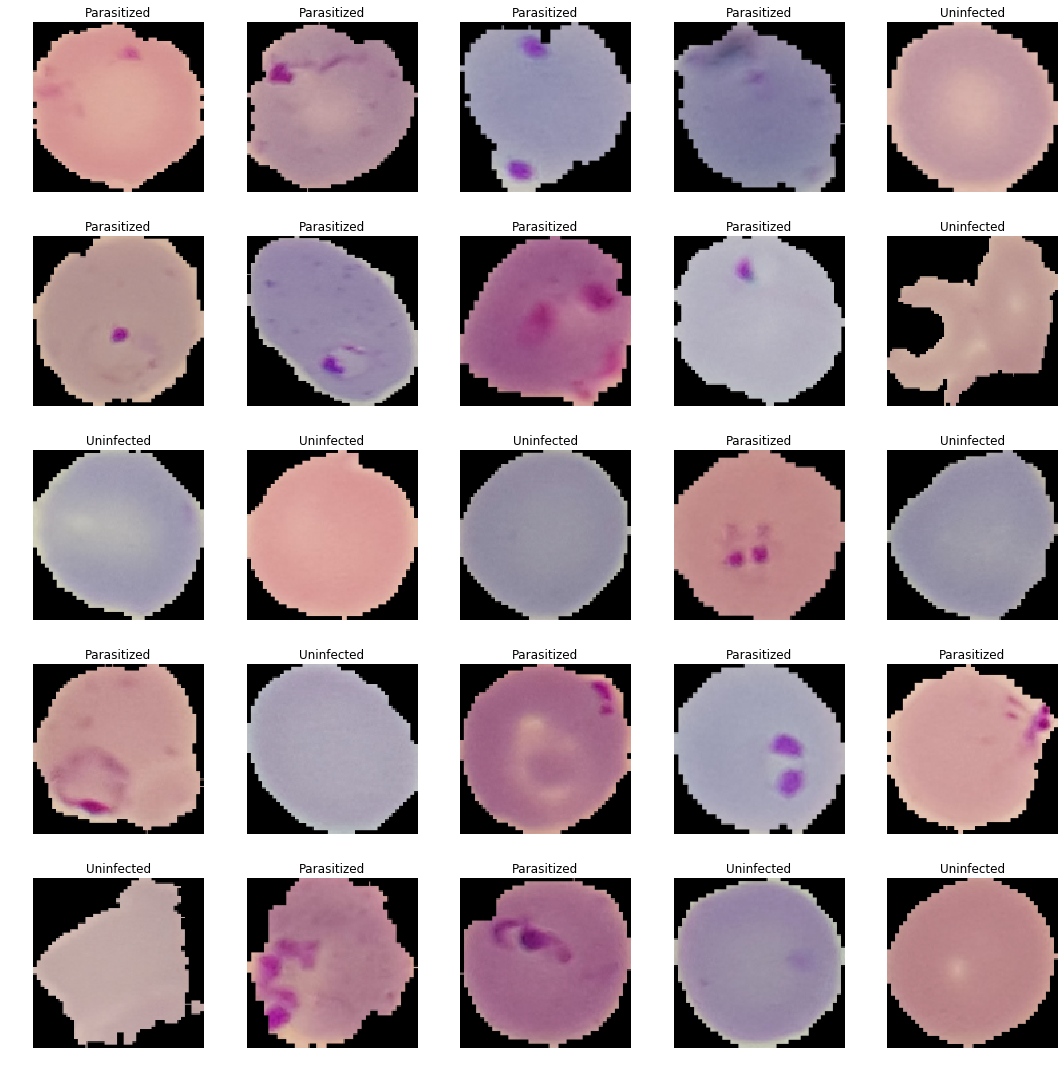

In [19]:
data.show_batch(rows=5, figsize=(15,15))

## Training: resnet34

If you do not know what to use, it is a good choice to start with a Residual Network with 34 layers. Not too small and not too big...
In the tutorials listed above the authors used:
- a custom, but small, ResNet (PyImagesearch)
- a VGG19 (TowardsDataScience)

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).


In [24]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### Training strategy
- We will employ the  *fit1cycle* method developed by  Leslie N. Smith  - see below for details: 

  - https://docs.fast.ai/callbacks.one_cycle.html

  - A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay - https://arxiv.org/abs/1803.09820
    
  - Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates - https://arxiv.org/abs/1708.07120

- Since this method is fast, we will employ only 10 epochs in this first Transfer Learning stage
- We will also save the network each epoch, if the performance gets better: https://docs.fast.ai/callbacks.html#SaveModelCallback


In [25]:
learn.fit_one_cycle(10, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='malaria-1')])
# Salve a rede (necessita regerar o databunch caso a gente continue)
learn.save('malaria-stage-1')
# Faça o deploy desta rede para podermos usar offline depois para fazer testes
exportStageTo(learn, path)

epoch,train_loss,valid_loss,error_rate,time
0,0.350304,0.212020,0.080022,01:05
1,0.230284,0.155553,0.057158,01:04
2,0.169989,0.130782,0.047360,01:04
3,0.137910,0.120661,0.042461,01:05
4,0.120630,0.118833,0.041553,01:03
5,0.110480,0.106493,0.036835,01:02
6,0.102611,0.105033,0.037743,01:01
7,0.094060,0.103336,0.037380,01:01
8,0.086851,0.103972,0.036110,01:02
9,0.083993,0.103802,0.036110,01:00


## Results for ResNet34

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

Look at you worst results:

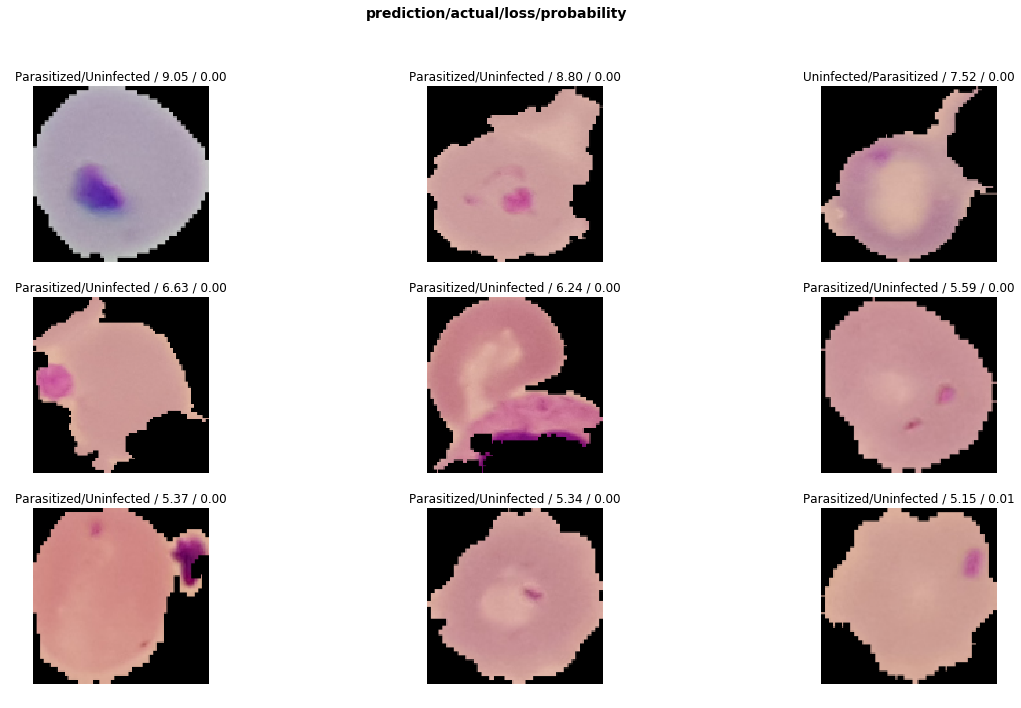

In [27]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=False)

Now, do the same but highlight with a heatmap what induced the wrong classification:

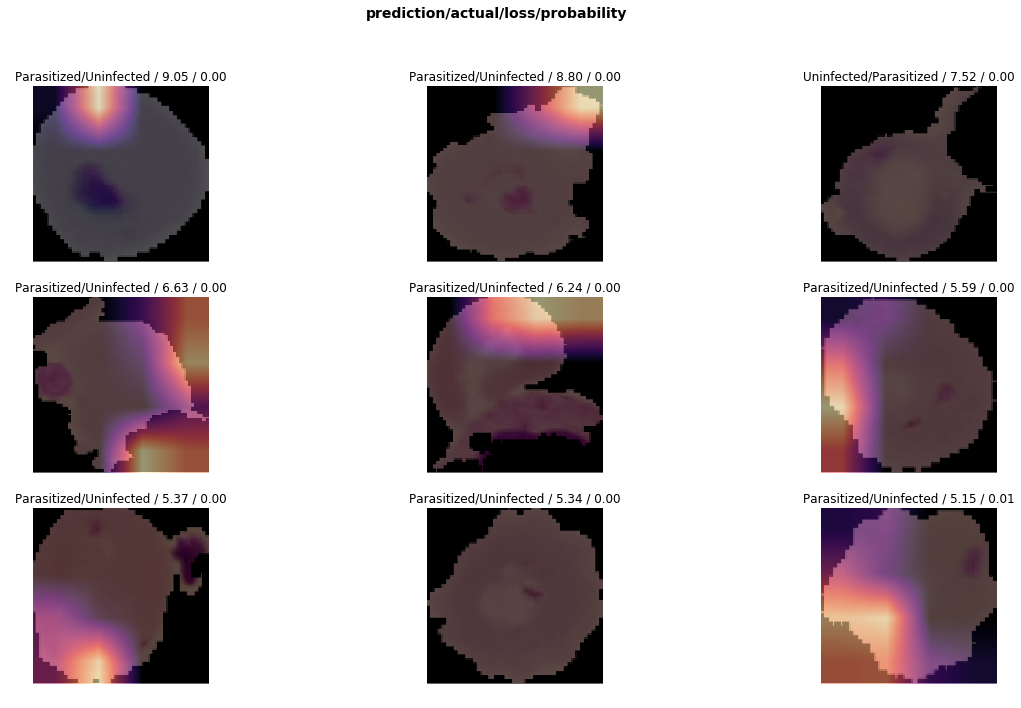

In [28]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=True)

### Show the confusion Matrix

It doesn't make much sense with only two classes, but we'll do it anyway:  it makes beautiful pictures...

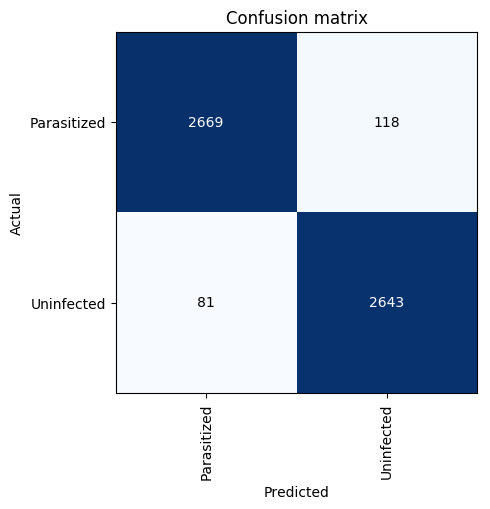

In [29]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

### Show your learning curve:

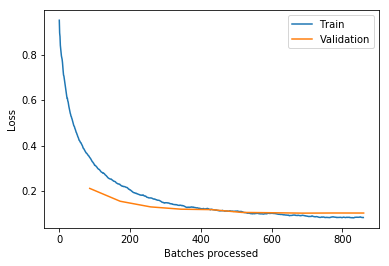

In [30]:
learn.recorder.plot_losses()

This result is really so good that it doesn't make sense to fine-tune the network. Let's employ a smaller network and try it again...

# ResNet18

This network is much simpler. Let's see if it does the job. 

We will create the DatBunch again, this time with a bigger batch size...

In [31]:
# Limit your augmentations: it's medical data! You do not want to phantasize data...
# Warping, for example, will let your images badly distorted, so don't do it!
# This dataset is big, so don't rotate the images either. Lets stick to flipping...
tfms = get_transforms(max_rotate=None, max_warp=None, max_zoom=1.0)
# Create the DataBunch!
# Remember that you'll have images that are bigger than 128x128 and images that are smaller, so squish them to occupy 
# exactly 128x128 pixels...
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH, 
                                  valid_pct = 0.2, bs=512)
#
print('Transforms = ', len(tfms))
# Save the DataBunch in case the training goes south... so you won't have to regenerate it..
# Remember: this DataBunch is tied to the batch size you selected. 
data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')
# Show the statistics of the Bunch...
print(data.classes)
data

Transforms =  2
['Parasitized', 'Uninfected']


ImageDataBunch;

Train: LabelList (22047 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: data;

Valid: LabelList (5511 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Parasitized,Uninfected,Parasitized,Uninfected,Parasitized
Path: data;

Test: None

In [32]:
learn18 = cnn_learner(data, models.resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:01, 28999302.58it/s]


In [33]:
learn18.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [34]:
learn18.fit_one_cycle(10, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='malaria18-1')])
# Salve a rede (necessita regerar o databunch caso a gente continue)
learn18.save('malaria18-stage-1')
# Faça o deploy desta rede para podermos usar offline depois para fazer testes
exportStageTo(learn18, path)

epoch,train_loss,valid_loss,error_rate,time
0,0.451016,0.253455,0.093812,01:02
1,0.300002,0.170524,0.059517,01:01
2,0.222290,0.151238,0.051533,01:01
3,0.182981,0.135591,0.046997,00:59
4,0.154560,0.128988,0.045364,01:00
5,0.135984,0.123360,0.043005,01:01
6,0.121266,0.124244,0.042461,01:00
7,0.111579,0.120839,0.039920,00:59
8,0.106545,0.120154,0.039376,00:59
9,0.101384,0.119603,0.039376,00:59


In [35]:
interp = ClassificationInterpretation.from_learner(learn18)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

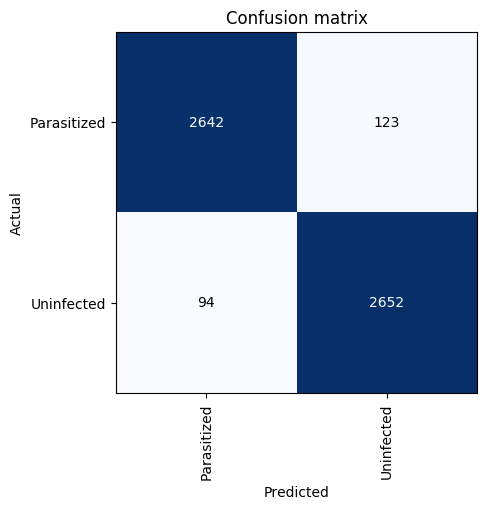

In [36]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

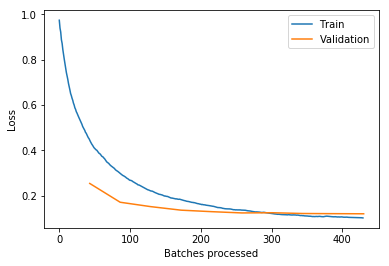

In [37]:
learn18.recorder.plot_losses()

96% accuracy! That is almost what Adrian Rosebrock also achieved with his custom ResNet in the PyImagesearch posting.   Now let''s see if we can become better if we do a wee fine-tuning. 



## Fine-Tune it!

In [38]:
# Unfreeze the network
learn18.unfreeze()
# Aqui você inclui uma faixa de taxas de aprendizado que é obtida com uma
# "regra de engenheiro" a partir do gráfico acima (ponha no slice): 
# - limite superior: uma ordem de grandeza acima do melhor aprendizado
# - limite inferior: melhor aprendizado
learn18.fit_one_cycle(30, max_lr=slice(1e-4,1e-5), 
                    callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='malaria18')])
# Agora, salve como estágio 2...
learn18.save('malaria18-stage-2')
# Deploy definitivo
exportStageTo(learn18, path)

epoch,train_loss,valid_loss,error_rate,time
0,0.097542,0.117639,0.038650,01:01
1,0.095917,0.115120,0.037380,01:04
2,0.090941,0.110814,0.037924,01:02
3,0.084017,0.110665,0.037924,01:02
4,0.077591,0.106868,0.035747,01:03
5,0.068637,0.101205,0.032662,01:00
6,0.058543,0.105028,0.034295,01:03
7,0.049572,0.108142,0.034295,01:01
8,0.041244,0.108563,0.033388,01:01
9,0.033827,0.109330,0.033025,01:01


**97% accuracy!** That is exactly  what Adrian Rosebrock also achieved with his custom ResNet in the PyImagesearch posting.   The *validation loss*, however, was becoming **worse** for the last epochs. This indicates that we have been *overfitting* from about epoch #20 on. If you want to deploy this network, I would suggest you to load the results from epoch 20 and generate a deployment network. It does not seem to become better, not with this network. 

In [39]:
interp = ClassificationInterpretation.from_learner(learn18)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

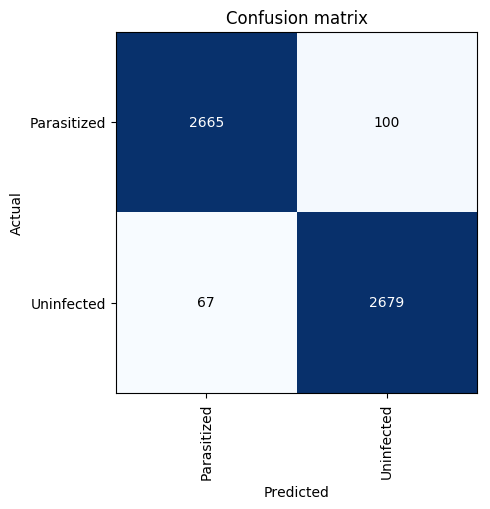

In [40]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

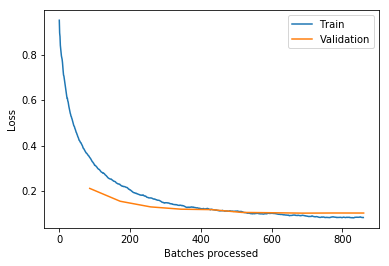

In [41]:
learn.recorder.plot_losses()

If you look at the curves above, you'll see that the **validation loss ** starts to grow in the last third of the training, suggesting that this part of the training only overfitted the network. 